# Tarea 3
## Prescriptive Analytics: Heuristics for Decision Making
### Wilmar Calderón - 201630701

The Flowshop Scheduling Problem (FSP) is a modeling methodology that aims to identify the optimal sequence for processing a set of jobs on a fixed sequence of machines, following the same order in each case, in the shortest possible time.

The problem's characteristics include a predetermined machine sequence for each job, deterministic processing times, continuous workflow, and the constraint that each machine can only process one job at a time.

### **Mathematical Formulation of the Flowshop Scheduling Problem**

The **Flowshop Scheduling Problem (FSP)** can be mathematically formulated as follows:

#### **Decision Variables**  
The sequence of jobs $S = \{s_1, s_2, \dots, s_j\}$ that minimizes the completion time:  
$$ s_k \in S $$

#### **Parameters**  
- $J = \{1,2, \dots, j\}$  ← Set of jobs.  
- $M = \{1,2, \dots, m\}$  ← Set of machines.  
- $p_{jm}$  ← Processing time of job $j$ on machine $m$.  

#### **Objective Function**  
Minimization of the completion time (makespan):  
$$ \min C_{\max}(S) $$

#### **Constraints**  
1. **Machine precedence constraint**  
   $$ C_{j,m} \geq C_{j,m-1} + p_{jm}, \quad \forall j \in J, m \in M, \quad m > 1 $$  
2. **Job precedence constraint**  
   $$ C_{j,m} \geq C_{j-1,m} + p_{jm}, \quad \forall j \in J, j > 1, m \in M $$  


In [123]:
#Loaded libraries for the evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import time

### Example of the instances for functions tuning and syntax checking

Example of the 1st instance of the 20x5 machinesxjobs instance from Taillard (1989)

In [124]:
# Define the instance
num_jobs = 20
num_machines = 5

# Processing times from the instance (each row is a machine, each column is a job)
processing_times = np.array([
    [54, 83, 15, 71, 77, 36, 53, 38, 27, 87, 76, 91, 14, 29, 12, 77, 32, 87, 68, 94],
    [79,  3, 11, 99, 56, 70, 99, 60,  5, 56,  3, 61, 73, 75, 47, 14, 21, 86,  5, 77],
    [16, 89, 49, 15, 89, 45, 60, 23, 57, 64,  7,  1, 63, 41, 63, 47, 26, 75, 77, 40],
    [66, 58, 31, 68, 78, 91, 13, 59, 49, 85, 85,  9, 39, 41, 56, 40, 54, 77, 51, 31],
    [58, 56, 20, 85, 53, 35, 53, 41, 69, 13, 86, 72,  8, 49, 47, 87, 58, 18, 68, 28]
])


Functions needed for the general processing

In [125]:
#Function to calculate timespan (Function that creates the "tiemtable"-schedule) corresponding to the time sequence of all jobs in the machines. Returns the total timespan for the sequence
def span (instance,seq,mode):
    machines,jobs=instance.shape
    timetable=np.zeros((machines,len(seq)))

    for j in range(len(seq)):
        job=seq[j]
        for m in range(machines):
            if j==0 and m==0:
                timetable[m,j]=instance[m,job]
            elif m==0:
                timetable[m,j]=timetable[m,j-1]+instance[m,job] #sum of consecutive jobs of the same machine
            elif j==0:
                timetable[m,j]=timetable[m-1,j]+instance[m,job] #sum of time of each job
            else:
                #To the time I need to add (instance[m,job]), I cannot start before the previous job at the machine is finished (t[m,j-1])
                #or before the previous task of the job has ended (t[m-1,j]), then I[m,job] must start afther the max(t[m,j-1],t[m-1,j])
                timetable[m,j]=max(timetable[m-1,j],timetable[m,j-1])+instance[m,job] 
    if mode==1:
        return timetable,timetable[-1,-1] #returns the matrix and the total timespan. USed to make the return more efficient for local search
    else:
        return timetable[-1,-1] #returns the lower right part of the matrix: Total timespan needed to cover all the jobs                   


In [126]:
#Function to calculate timespan
sequence=np.arange(len(processing_times[0]))
time_test,val=span(processing_times,sequence,1)
print(val)

1448.0


In [127]:
#Function that enables the gantt view of the sequence
def plot_gantt_chart(sequence, time_matrix, processing_times):
    """Visualize the job schedule as a Gantt chart."""
    num_machines, num_jobs = processing_times.shape
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors
    
    for j, job in enumerate(sequence):
        for m in range(num_machines):
            start_time = time_matrix[m, j] - processing_times[m, job]
            duration = processing_times[m, job]
            ax.broken_barh([(start_time, duration)], (m - 0.4, 0.8), color=colors(job), edgecolor='black')
    
    ax.set_xlabel("Time")
    ax.set_xticks(range(0,1600,200))    
    ax.set_xlim(xmin=0.0, xmax=1500)
    ax.set_ylabel("Machines")
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f"Machine {m+1}" for m in range(num_machines)])
    ax.set_title("Flowshop Scheduling - Gantt Chart")
    
    # Add legend
    legend_patches = [mpatches.Patch(color=colors(j), label=f"Job {j+1}") for j in sequence]
    ax.legend(handles=legend_patches, title="Jobs", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

C:\Users\wilma\AppData\Local\Temp\ipykernel_28252\2064342752.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors


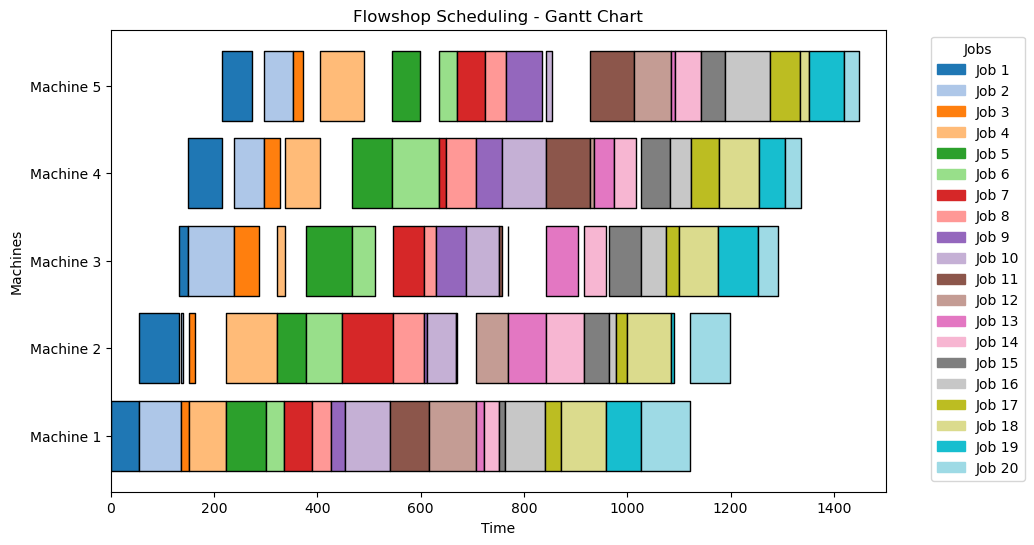

In [128]:
#Example of the first sequence: As if the sequence was the same as the original sequence without checking
plot_gantt_chart(sequence,time_test,processing_times)

Constructive Solution
Based on the approach of Nawas-Enscore-Ham Heuristic , described as follows:

(Reference: Nawaz, M., Emory-Enscore, E., & Ham, I. (1983). A heuristic algorithm for the m-machine, n-job flow-shop sequencing problem. Omega, 91-95. doi:https://doi.org/10.1016/0305-0483(83)90088-9)

#### **NEH Algorithm Steps**

1. **Calculate the total processing time for each job:**  
   For each job \( j \) in \( \{1, ... , J\} \):  
   $$  
   T[j] = \sum_{m=1}^{M} P[j][m]  
   $$

2. **Sort jobs in descending order of \( T[j] \).**  

3. **Initialize the sequence with the first two jobs in the best order:**  
   - Evaluate both possible sequences.  
   - Select the one that minimizes the makespan.  

4. **For each job \( i \) from the third to the \( n \)-th:**  
   - Insert the job in all possible positions of the current sequence.  
   - Compute the makespan for each insertion.  
   - Select the insertion that minimizes the makespan.  

5. **Return the best sequence found.**


In [129]:
def constructive(instance):
    machines,n_jobs=instance.shape
    t_ij=np.sum(instance,axis=0) #Time consumed for each job (Step 1)
    sorted_t=np.argsort(-t_ij) #arranges it in Descending order
    seq2=sorted_t.copy()
    span1=span(instance,sorted_t,0)
    seq2[0],seq2[1]=seq2[1],seq2[0]
    span2=span(instance,seq2,0)
    # (Step 2)
    if span2>=span1: 
        f_seq=sorted_t
        best_t=span1
    else:
        f_seq=seq2
        best_t=span2
    flag=0
    # (Step 3)
    new_s=f_seq.copy()
    for i in range(2,n_jobs):
        for p in range(i,len(f_seq)):

            new_s[p],new_s[i]=new_s[i],new_s[p]
            new_t=span(instance,new_s,0)
            # (Step 4)
            if new_t<best_t:
                best_t=new_t
                best_seq=list(new_s)
                flag=1
    if flag==0:
        best_seq=list(f_seq)
    return best_seq,best_t


In [130]:
#Results for the constructive algorithm
b_seq,best_t=constructive(processing_times)
print(best_t)
time_test,val=span(processing_times,b_seq,1)
print(b_seq)
print(val)


1427.0
[4, 17, 2, 16, 12, 8, 7, 14, 11, 13, 10, 15, 6, 3, 9, 1, 5, 0, 19, 18]
1427.0


C:\Users\wilma\AppData\Local\Temp\ipykernel_28252\2064342752.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors


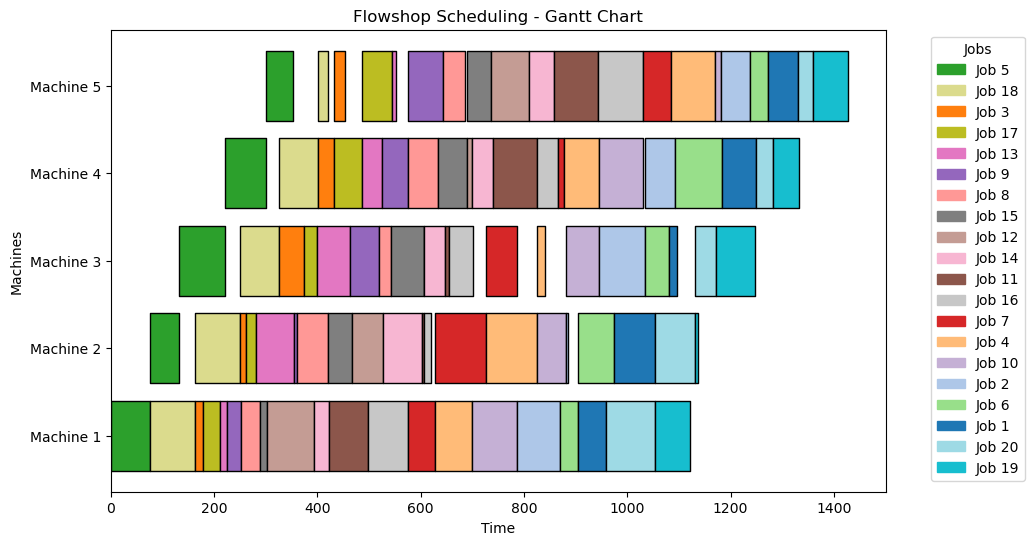

In [131]:
#Gantt chart with the constructive solution
plot_gantt_chart(b_seq,time_test,processing_times)

Now, let's implement Tabu search

#### **Tabu Search Algorithm Pseudocode**

1. **Initialization:**  
   - Choose (or construct) an initial solution $S_0$.  
   - Assign:  
     $$
     S \gets S_0, \quad f^* \gets f(S_0), \quad S^* \gets S_0, \quad T \gets \emptyset
     $$  

2. **Search:**  
   - While the termination criterion is not met (if $\text{iter} < \text{max\_iter}$):  
     - Select the best solution $S'$ in the admissible neighborhood:  
       $$
       S \gets \arg\min_{S' \in \mathcal{N}(S)} f(S')  
       $$
     - If $f(S) < f^*$, then:  
       - Update:  
         $$
         f^* \gets f(S), \quad S^* \gets S  
         $$
     - Register the move in the tabu list $T$.  
     - If ($\text{len}(T) < \text{tabu\_tenure}$):  
       - If necessary, remove the oldest entry from $T$.  

3. **Return** the best solution found $S^*$ and its value $f^*$.  



In [132]:
def tabu_search(initial_seq,initial_val,instance,max_iter,tabu_tenure):
    #definitios for the intiialization of the tabu search
        #S*<-S0
    s_ast=initial_seq.copy()
        #F(S*)<-F(S0)
    f_ast=initial_val
        #S<-S0
    s=initial_seq.copy()
        #T<-[]
    T=[]
    for _ in range(max_iter):
        N_s=[] #Initialization of N(S)
        #Create the neighbourhood of N(S) based in 1:1 swapping
        new_s=list(s)#creates a copy that will be modified
        # Randomly select pairs of jobs to swap
        num_swaps = random.randint(1,len(s))
        swap_indices = [random.sample(range(1, len(s)), 2) for _ in range(num_swaps)]

        for i, j in swap_indices:                    #Creates a new sequence S'
            new_s[i],new_s[j]=new_s[j],new_s[i]
                #If S' is not in the tabu list, add it to the feasible Neighbourhood Ñ(S)
            if new_s not in T:
                #calculates the time span (F(S'))
                f_s=span(instance,new_s,0)
                #adds the sequence S' and its value f(S') to Ñ(S)
                N_s.append((list(new_s),f_s))

        if N_s: #chacks that the neighbourhood in not empty
            N_s.sort(key=lambda x: x[1]) #sorts the list is ascending order 
            #obtains the solution S' that satisfies S'=argmin(f(s) forall f(s) in N(S))
            s_val,f_val=N_s[0]
            #if f(S') < f (S∗), then set f(S∗) <- f (S') and S* <- S' 
            if f_val < f_ast:
                f_ast=f_val
                s_ast=list(s_val)#.copy()
                #sets  S <-S*;
                s=list(s_ast)#.copy()
        T.append(s)
        #Keeps the length of tabu list under the parameter tabu_tenure
        if len(T)>tabu_tenure:
            T.pop(0) #removes the oldest value to keep |T|=tabu_tenure
    return s


In [133]:
#Function that reads the instance and creates the constructive an Tabu Search solution
def evaluation(processing_time,max_iter,tabu_tenure):
    s0,f_s0=constructive(processing_time)
    s_ast=tabu_search(s0,f_s0,processing_time,max_iter,tabu_tenure)
    f_ast=span(processing_time,s_ast,0)
    return f_ast,s_ast

1332.0


C:\Users\wilma\AppData\Local\Temp\ipykernel_28252\2064342752.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors


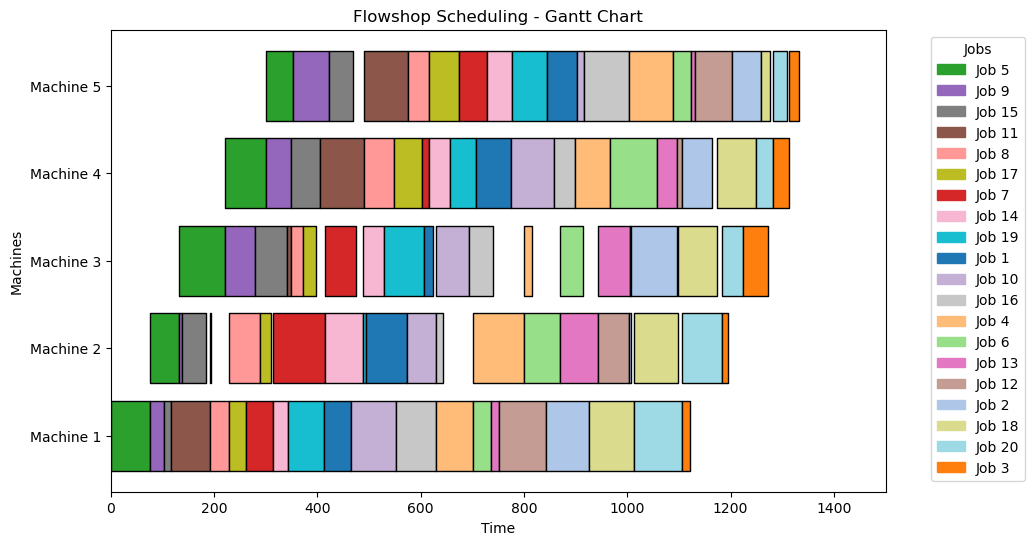

In [134]:
#Test for 1 instance to review if more instances can be evaluated
max_iter=100
tabu_tenure=5

a,s_a=evaluation(processing_times,max_iter,tabu_tenure)
print(a)

time_test,val=span(processing_times,s_a,1)
plot_gantt_chart(s_a,time_test,processing_times)

In [135]:
#Function to read in batch multiple instances
def read_instances_from_file(filename):
    """Read and parse multiple Flowshop instances from a text file, extracting the processing times and lower bound."""
    instances = []
    lower_bounds = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith("number of jobs"):
                parts = list(map(int, lines[i + 1].split()))
                num_jobs, num_machines, _, _, lower_bound = parts
                lower_bounds.append(lower_bound)
                i += 3  # Move to processing times
                processing_times = []
                for _ in range(num_machines):
                    processing_times.append(list(map(int, lines[i].split())))
                    i += 1
                instances.append(np.array(processing_times))
            else:
                i += 1
    return instances, lower_bounds

#Root mean Squared Error
def rmse(predictions, targets):
    return np.sqrt(((np.array(predictions) - np.array(targets)) ** 2).mean())

#Mean absolute error
def mae(predictions, targets):
    return np.mean((np.array(predictions) - np.array(targets))/np.array(targets))


In [136]:
random.seed(10) #Fixes the random state

#Function to evaluate multiple values for max_iter and tabu_tenure
def performance_eval(instances,lower_b,train_indices, max_iter,tabu_tenure):
    results=[]
    aux=[]
    for iter in max_iter:
        for t in tabu_tenure:
            start_time = time.time()
            sol=[]
            print("\n parameters:")
            print("max iterations: ",iter)
            print("Tabu Tenure: ",t)           
            for ins in range(len(instances)):
                st2 = time.time()
                print("progress="+str(round(100*(ins+1)/len(instances)))+"%")
                pred,s_a=evaluation(instances[ins],int(iter),int(t))
                sol.append(pred)
                aux.append([train_indices[ins],iter,t,pred,lower_b[ins],time.time()-st2])

            metric1=rmse(sol,lower_b)
            metric2=mae(sol,lower_b)
            results.append([iter,t,metric1,metric2,time.time()-start_time])
            print("runtime: "+str(round(results[-1][-1],2))+" s")
    # print("test", aux)
    return results, aux




In [137]:
instances=[]
lower_b=[]

files=["tai20_5.txt","tai20_10.txt","tai20_20.txt",
       "tai50_5.txt","tai50_10.txt","tai50_20.txt",
       "tai100_5.txt","tai100_10.txt","tai100_20.txt",
       "tai200_10.txt","tai200_20.txt","tai500_20.txt"]

for i in files:
    m_i,lb_i=read_instances_from_file(i)
    instances.extend(m_i)
    lower_b.extend(lb_i)


max_iter=[300,500,750,1000]
tabu_tenure=[50]

# Sample 50% of instances
sample_size = int(0.5 * len(instances))
train_indices = random.sample(range(len(instances)), sample_size)
# print(train_indices)
# print(len(train_indices))

# Get the corresponding lower bounds for the sampled instances
train_instances = [instances[i] for i in train_indices]
train_lower_b = [lower_b[i] for i in train_indices]


res,aux=performance_eval(train_instances,train_lower_b,train_indices, max_iter,tabu_tenure)
res=np.array(res)
aux=np.array(aux)
# print(aux.shape)

##### If you want to run the sensibility analysis, uncomment lines below ####
##### FROM HERE ####
#  res,aux=performance_eval(instances,lower_b,[x for x in range(len(lower_b))],max_iter,tabu_tenure)
# res=np.array(res)
# aux=np.array(aux)

#Stores the results of the sensibility analysis
df=pd.DataFrame({"max_iter":res[:,0],"tenure":res[:,1],"RMSE":res[:,2],"MAE":res[:,3],"time":res[:,4]})
filepath = 'results_h3-V2.xlsx'
df.to_excel(filepath, index=False)

#Stores the results of the sensibility analysis
df2=pd.DataFrame({"instances":aux[:,0],"max_iter":aux[:,1],"tenure":aux[:,2],"pred":aux[:,3],"BKS":aux[:,4],"time(s)":aux[:,5]})
filepath2 = 'results_h3-details.xlsx'
df2.to_excel(filepath2, index=False)

##### TO HERE ####


 parameters:
max iterations:  300
Tabu Tenure:  50
progress=2%
progress=3%
progress=5%
progress=7%
progress=8%
progress=10%
progress=12%
progress=13%
progress=15%
progress=17%
progress=18%
progress=20%
progress=22%
progress=23%
progress=25%
progress=27%
progress=28%
progress=30%
progress=32%
progress=33%
progress=35%
progress=37%
progress=38%
progress=40%
progress=42%
progress=43%
progress=45%
progress=47%
progress=48%
progress=50%
progress=52%
progress=53%
progress=55%
progress=57%
progress=58%
progress=60%
progress=62%
progress=63%
progress=65%
progress=67%
progress=68%
progress=70%
progress=72%
progress=73%
progress=75%
progress=77%
progress=78%
progress=80%
progress=82%
progress=83%
progress=85%
progress=87%
progress=88%
progress=90%
progress=92%
progress=93%
progress=95%
progress=97%
progress=98%
progress=100%
runtime: 6751.08 s

 parameters:
max iterations:  500
Tabu Tenure:  50
progress=2%
progress=3%
progress=5%
progress=7%
progress=8%
progress=10%
progress=12%
progress=13%
pr

1339.0


C:\Users\wilma\AppData\Local\Temp\ipykernel_28252\2064342752.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors


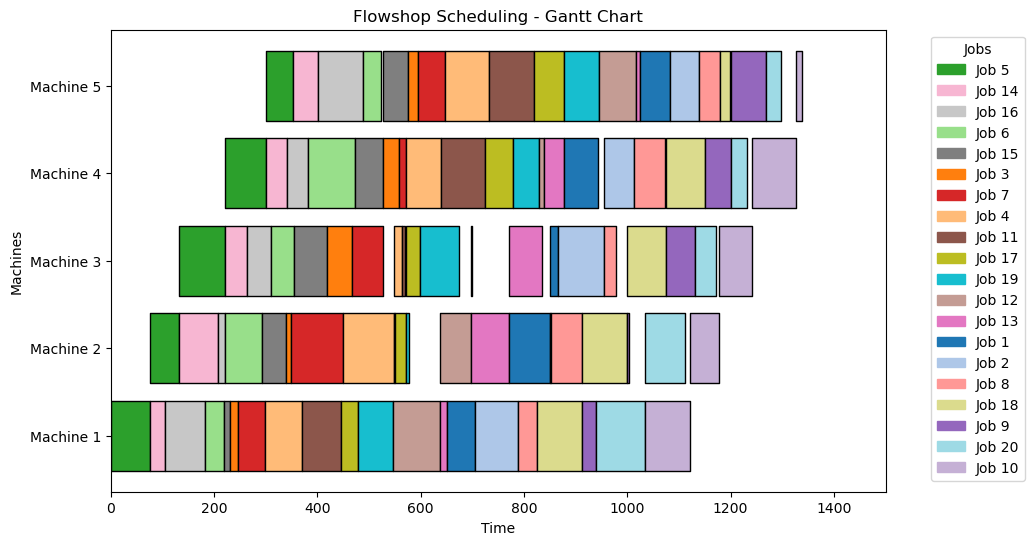

In [138]:
## Example of the schedule obtained with the max_iter and tabu_tenure tuned parameters.
max_iter=100
tabu_tenure=20

random.seed(10)
a,s_a=evaluation(processing_times,max_iter,tabu_tenure)
print(a)

time_test,val=span(processing_times,s_a,1)
plot_gantt_chart(s_a,time_test,processing_times)

### Now, if you want to evaluate an instance, you can modify the line "Instance" with the np.array of your instance and then execute all the line below

1339.0


C:\Users\wilma\AppData\Local\Temp\ipykernel_28252\2064342752.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", num_jobs)  # Generate unique colors


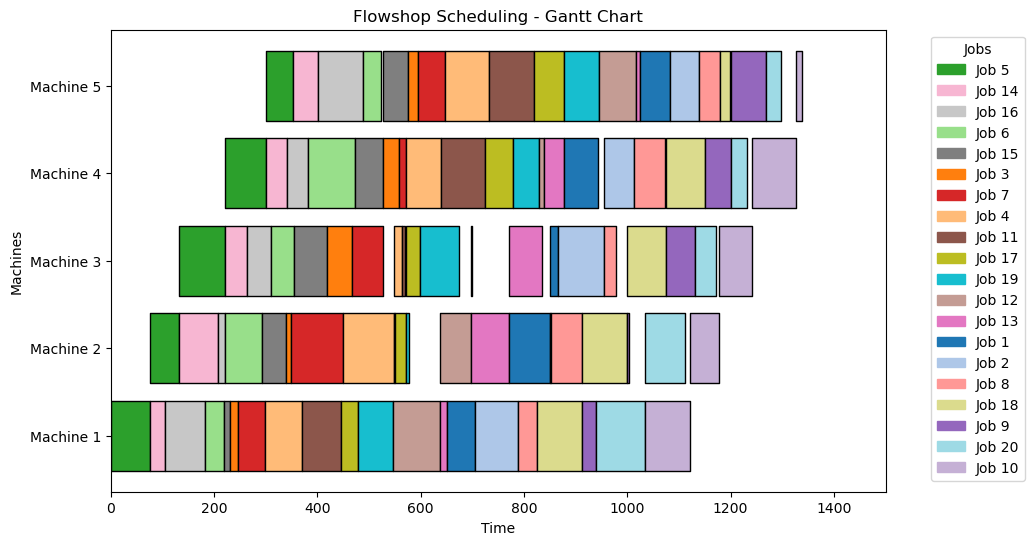

In [139]:
# Processing times from the instance (each row is a machine, each column is a job)
instance = np.array([
    [54, 83, 15, 71, 77, 36, 53, 38, 27, 87, 76, 91, 14, 29, 12, 77, 32, 87, 68, 94],
    [79,  3, 11, 99, 56, 70, 99, 60,  5, 56,  3, 61, 73, 75, 47, 14, 21, 86,  5, 77],
    [16, 89, 49, 15, 89, 45, 60, 23, 57, 64,  7,  1, 63, 41, 63, 47, 26, 75, 77, 40],
    [66, 58, 31, 68, 78, 91, 13, 59, 49, 85, 85,  9, 39, 41, 56, 40, 54, 77, 51, 31],
    [58, 56, 20, 85, 53, 35, 53, 41, 69, 13, 86, 72,  8, 49, 47, 87, 58, 18, 68, 28]
])

random.seed(10)
a,s_a=evaluation(instance,max_iter,tabu_tenure)
print(a)

time_test,val=span(instance,s_a,1)
plot_gantt_chart(s_a,time_test,instance)



In [ ]:
# max_iter=[100]
# tabu_tenure=[20]
# ##### If you want to run the sensibility analysis, uncomment lines below ####
# ##### FROM HERE ####
# res1,aux1=performance_eval(instances,lower_b,[x for x in range(len(lower_b))],max_iter,tabu_tenure)
# res1=np.array(res1)
# aux1=np.array(aux1)

# #Stores the results of the sensibility analysis
# df11=pd.DataFrame({"max_iter":res1[:,0],"tenure":res1[:,1],"RMSE":res1[:,2],"MAE":res1[:,3],"time":res1[:,4]})
# filepath11 = 'results_h3-V2-INS.xlsx'
# df11.to_excel(filepath11, index=False)

# #Stores the results of the sensibility analysis
# df21=pd.DataFrame({"instances":aux1[:,0],"max_iter":aux1[:,1],"tenure":aux1[:,2],"pred":aux1[:,3],"BKS":aux1[:,4],"time(s)":aux1[:,5]})
# filepath21 = 'results_h3-details-INS.xlsx'
# df21.to_excel(filepath21, index=False)

##### TO HERE ####


 parameters:
max iterations:  100
Tabu Tenure:  20
progress=1%
progress=2%
progress=2%
progress=3%
progress=4%
progress=5%
progress=6%
progress=7%
progress=8%
progress=8%
progress=9%
progress=10%
progress=11%
progress=12%
progress=12%
progress=13%
progress=14%
progress=15%
progress=16%
progress=17%
progress=18%
progress=18%
progress=19%
progress=20%
progress=21%
progress=22%
progress=22%
progress=23%
progress=24%
progress=25%
progress=26%
progress=27%
progress=28%
progress=28%
progress=29%
progress=30%
progress=31%
progress=32%
progress=32%
progress=33%
progress=34%
progress=35%
progress=36%
progress=37%
progress=38%
progress=38%
progress=39%
progress=40%
progress=41%
progress=42%
progress=42%
progress=43%
progress=44%
progress=45%
progress=46%
progress=47%
progress=48%
progress=48%
progress=49%
progress=50%
progress=51%
progress=52%
progress=52%
progress=53%
progress=54%
progress=55%
progress=56%
progress=57%
progress=58%
progress=58%
progress=59%
progress=60%
progress=61%
progress=6